In [1]:
import json
from binding_affinity_predictor import *
from admet_selenium_extraction import automated_admet
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from sklearn.metrics import silhouette_score, pairwise_distances
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from Chromosome import *
from GeneticMutation import *

In [2]:
def get_admet(molecules):
    return automated_admet(molecules)

In [3]:
def get_pareto_ranking(fitness_scores):
    def dominates(sol1, sol2):
        return all(x <= y for x, y in zip(sol1, sol2)) and any(x < y for x, y in zip(sol1, sol2))
    
    num_solutions = len(fitness_scores)
    pareto_levels = np.zeros(num_solutions, dtype=int)  # Initialize ranks

    for i in range(num_solutions):
        for j in range(num_solutions):
            if i != j:
                if dominates(fitness_scores[j], fitness_scores[i]):
                    pareto_levels[i] += 1  # Increase rank if solution i is dominated by solution j

    return pareto_levels

In [4]:
def get_cluster(molecules):
    # Create similarity matrix
    fpgen = AllChem.GetMorganGenerator()
    molecules_fingerprint = [fpgen.GetFingerprint(Chem.MolFromSmiles(molecule)) for molecule in molecules]

    # Manually calculate the Tanimoto distance matrix
    n = len(molecules_fingerprint)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            tanimoto_sim = DataStructs.TanimotoSimilarity(molecules_fingerprint[i], molecules_fingerprint[j])
            dist_matrix[i, j] = 1 - tanimoto_sim
            dist_matrix[j, i] = dist_matrix[i, j]  # Matrix is symmetric

    condensed_dist_matrix = squareform(dist_matrix)
    # Cluster the similarity matrix while identfying optimal number of clusters
    cluster_linkage = linkage(condensed_dist_matrix, method='average')
    max_clusters = min(len(molecules)//2, 50)
    # Calculate silhouette score for each number of clusters
    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        labels = fcluster(cluster_linkage, n_clusters, criterion='maxclust')
        score = silhouette_score(dist_matrix, labels, metric='precomputed')
        silhouette_scores.append(score)
    # Optimal number of clusters is the one with the maximum silhouette score
    optimal_clusters = np.argmax(silhouette_scores) + 2
    print(f'Optimal number of clusters: {optimal_clusters}')

    # Cluster the molecules
    labels = fcluster(cluster_linkage, optimal_clusters, criterion='maxclust')
    return labels

In [5]:
def get_scores(population, fitness_scores):
    # (Pareto Ranking, Cluster)
    scores = list(zip(get_pareto_ranking(fitness_scores), get_cluster(population)))
    return scores

In [6]:
def get_binding_affinity(molecules):
    model_filepath = "./trainer.pkl"
    predicted_affinity = get_binding_affinities(molecules, model_filepath)
    return predicted_affinity

In [7]:
def get_fitness(molecules):
    # Get Admet and Get SA are merged
    admet_props = get_admet(molecules).values.tolist()

    # Predicted binding affinity (e.g., lower values are better for binding affinity)
    binding_affinity = get_binding_affinity(molecules)
    for i in range(len(admet_props)):
        admet_props[i].append(binding_affinity[i])

    # for i in range(len(admet_props)):
    #     for index in [2, 3, 4, 9, 10, 11, 12]:
    #         admet_props[i][index] = -admet_props[i][index]
    admet_props = [tuple(admet_prop) for admet_prop in admet_props]

    return admet_props

In [8]:
with open("../history/log.json", "r") as f:
    history = json.load(f)

In [9]:
last_population = history[-1]["population_smiles"]

In [10]:
print(len(list(set(last_population))))
print("\n".join(list(set(last_population))))

16
CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CBC(=O)O)C(=O)O)cc1
CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1
NN
N=CN
S=c1nc[nH]c2nc[nH]c12
Nc1ccn(C2OC(CO)C(O)=C2O)c(=O)n1
C=C(NC=N)C(=S)N=C(N)N(C)c1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1
C=C(NC=N)C(=S)N=C(N)CC1OC(n2ccc(N)nc2=O)C(O)C1O
C=C(NC=N)C(=S)N=C(NC(CCC(=O)O)C(=O)O)c1ccc(N(C)Cc2cnc3nc(N)nc(N)c3n2)cc1
Nc1ccn(C2OC(CO)C(O)C2O)c(=O)n1
Nc1ccn(C2OC(O)(CO)CC2O)c(=O)n1
C=C(NC=N)C(=S)N=C(N)C(=O)C(CCC(=O)O)NC(=O)c1ccc(N(C)C(N)=NC(=S)C(=C)NC=N)cc1
Nc1nc(=S)c2[nH]cnc2[nH]1
CC(=NC=C(N)CN)N=C(N)N=CN
NO
C=C(N)NC=N


In [14]:
fitness = history[-1]["scores"]

In [15]:
scores = get_scores(last_population, fitness)

Optimal number of clusters: 6


In [16]:
scores

[(0, 3),
 (0, 2),
 (0, 6),
 (0, 5),
 (0, 4),
 (0, 1),
 (0, 3),
 (0, 2),
 (0, 5),
 (0, 4),
 (0, 1),
 (0, 3),
 (0, 2),
 (0, 3),
 (0, 2),
 (0, 3)]

In [17]:
highest = []
highest_fitness = []
for index, score in enumerate(scores):
    if score[0] == 0:
        print(last_population[index], scores[index])
        highest.append(last_population[index])
        highest_fitness.append(fitness[index])

highest_fitness = dict(zip(highest, highest_fitness))

C=C(NC=N)C(=S)N=C(NC(CCC(=O)O)C(=O)O)c1ccc(N(C)Cc2cnc3nc(N)nc(N)c3n2)cc1 (0, 3)
Nc1ccn(C2OC(CO)C(O)=C2O)c(=O)n1 (0, 2)
CC(=NC=C(N)CN)N=C(N)N=CN (0, 6)
N=CN (0, 5)
NN (0, 4)
S=c1nc[nH]c2nc[nH]c12 (0, 1)
CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1 (0, 3)
Nc1ccn(C2OC(CO)C(O)C2O)c(=O)n1 (0, 2)
C=C(N)NC=N (0, 5)
NO (0, 4)
Nc1nc(=S)c2[nH]cnc2[nH]1 (0, 1)
C=C(NC=N)C(=S)N=C(N)N(C)c1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1 (0, 3)
C=C(NC=N)C(=S)N=C(N)CC1OC(n2ccc(N)nc2=O)C(O)C1O (0, 2)
CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CBC(=O)O)C(=O)O)cc1 (0, 3)
Nc1ccn(C2OC(O)(CO)CC2O)c(=O)n1 (0, 2)
C=C(NC=N)C(=S)N=C(N)C(=O)C(CCC(=O)O)NC(=O)c1ccc(N(C)C(N)=NC(=S)C(=C)NC=N)cc1 (0, 3)


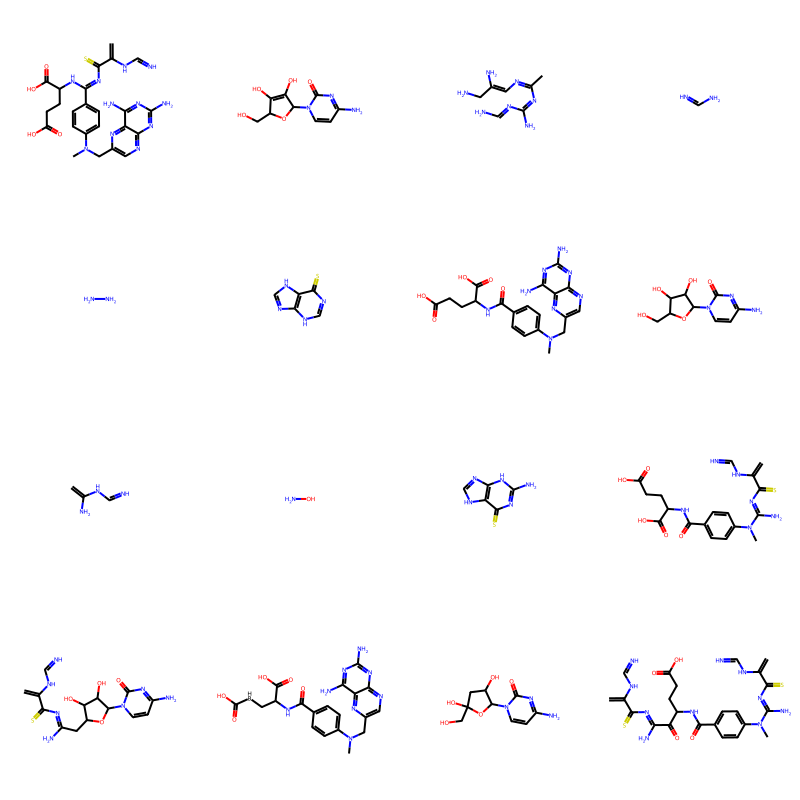

In [18]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in highest], molsPerRow=4, subImgSize=(200,200))

In [19]:
# ['Lipinski', 'PPB', 'logVDss', 'CYP3A4-inh', 'CYP3A4-sub', 
# 'CYP2D6-inh', 'CYP2D6-sub', 'cl-plasma', 't0.5', 'DILI', 'hERG', 'Synth', 'Binding Affinity', 'HLG']

prop = 2

reversible = [0, 2, 4, 6, 8, 9, 11, 12]
is_reversed = not prop in reversible
highest_prop = sorted(highest, key=lambda x: highest_fitness[x][prop], reverse=is_reversed)

top_props = []

for prop in range(14):
    top_prop = []
    past_imp = 0

    reversible = [0, 2, 4, 6, 8, 9, 11, 12, 13]
    is_reversed = not prop in reversible
    highest_prop = sorted(highest, key=lambda x: highest_fitness[x][prop], reverse=is_reversed)

    for i in range(len(highest)):
        # print(highest_prop[i], highest_fitness[highest_prop[i]][prop])
        if highest_prop[i] in top_prop:
            continue
        top_prop.append(highest_prop[i])
        if highest_prop[i] in ["S=c1nc[nH]c2nc[nH]c12", "Nc1nc(=S)c2[nH]cnc2[nH]1"]:
            past_imp += 1

        if past_imp >= 2:
            break
    top_props += top_prop

In [20]:
from collections import Counter
print(Counter(top_props))

Counter({'S=c1nc[nH]c2nc[nH]c12': 14, 'Nc1nc(=S)c2[nH]cnc2[nH]1': 14, 'N=CN': 10, 'NN': 10, 'NO': 10, 'C=C(N)NC=N': 9, 'CC(=NC=C(N)CN)N=C(N)N=CN': 8, 'Nc1ccn(C2OC(CO)C(O)C2O)c(=O)n1': 8, 'C=C(NC=N)C(=S)N=C(N)CC1OC(n2ccc(N)nc2=O)C(O)C1O': 7, 'CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CBC(=O)O)C(=O)O)cc1': 7, 'Nc1ccn(C2OC(CO)C(O)=C2O)c(=O)n1': 7, 'C=C(NC=N)C(=S)N=C(NC(CCC(=O)O)C(=O)O)c1ccc(N(C)Cc2cnc3nc(N)nc(N)c3n2)cc1': 6, 'CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1': 6, 'Nc1ccn(C2OC(O)(CO)CC2O)c(=O)n1': 6, 'C=C(NC=N)C(=S)N=C(N)C(=O)C(CCC(=O)O)NC(=O)c1ccc(N(C)C(N)=NC(=S)C(=C)NC=N)cc1': 5, 'C=C(NC=N)C(=S)N=C(N)N(C)c1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1': 4})


In [21]:
# Lipinski
# PPB
# logVDss
# CYP3A4-inh
# CYP3A4-sub
# CYP2D6-inh
# CYP2D6-sub
# cl-plasma
# t0.5
# DILI
# hERG
# Synthesizability
# Binding Affinity 

In [22]:
interesting = ["S=c1nc[nH]c2nc[nH]c12",
               "Nc1nc(=S)c2[nH]cnc2[nH]1",
               "Nc1c#cn(C2OC(OC=O)CC2=O)c(=O)n1",
               "S=c1nc2[nH]c3nc([nH]c13)N2",
               "C=C(CCC(C)O)N=C(N)S",
               "C=C1C(N)=NC(=O)N1C1(O)C(=O)CC1OO",
               "CC(=NC=C(N)NN)N=C(N)N=CN",
               "N=Cn1[nH]c2nc[nH]c2c1=S",
               "NC1NC(=S)c2[nH]cnc2N1",
               "Cc1c(=S)ncn2[nH]cnc12"]

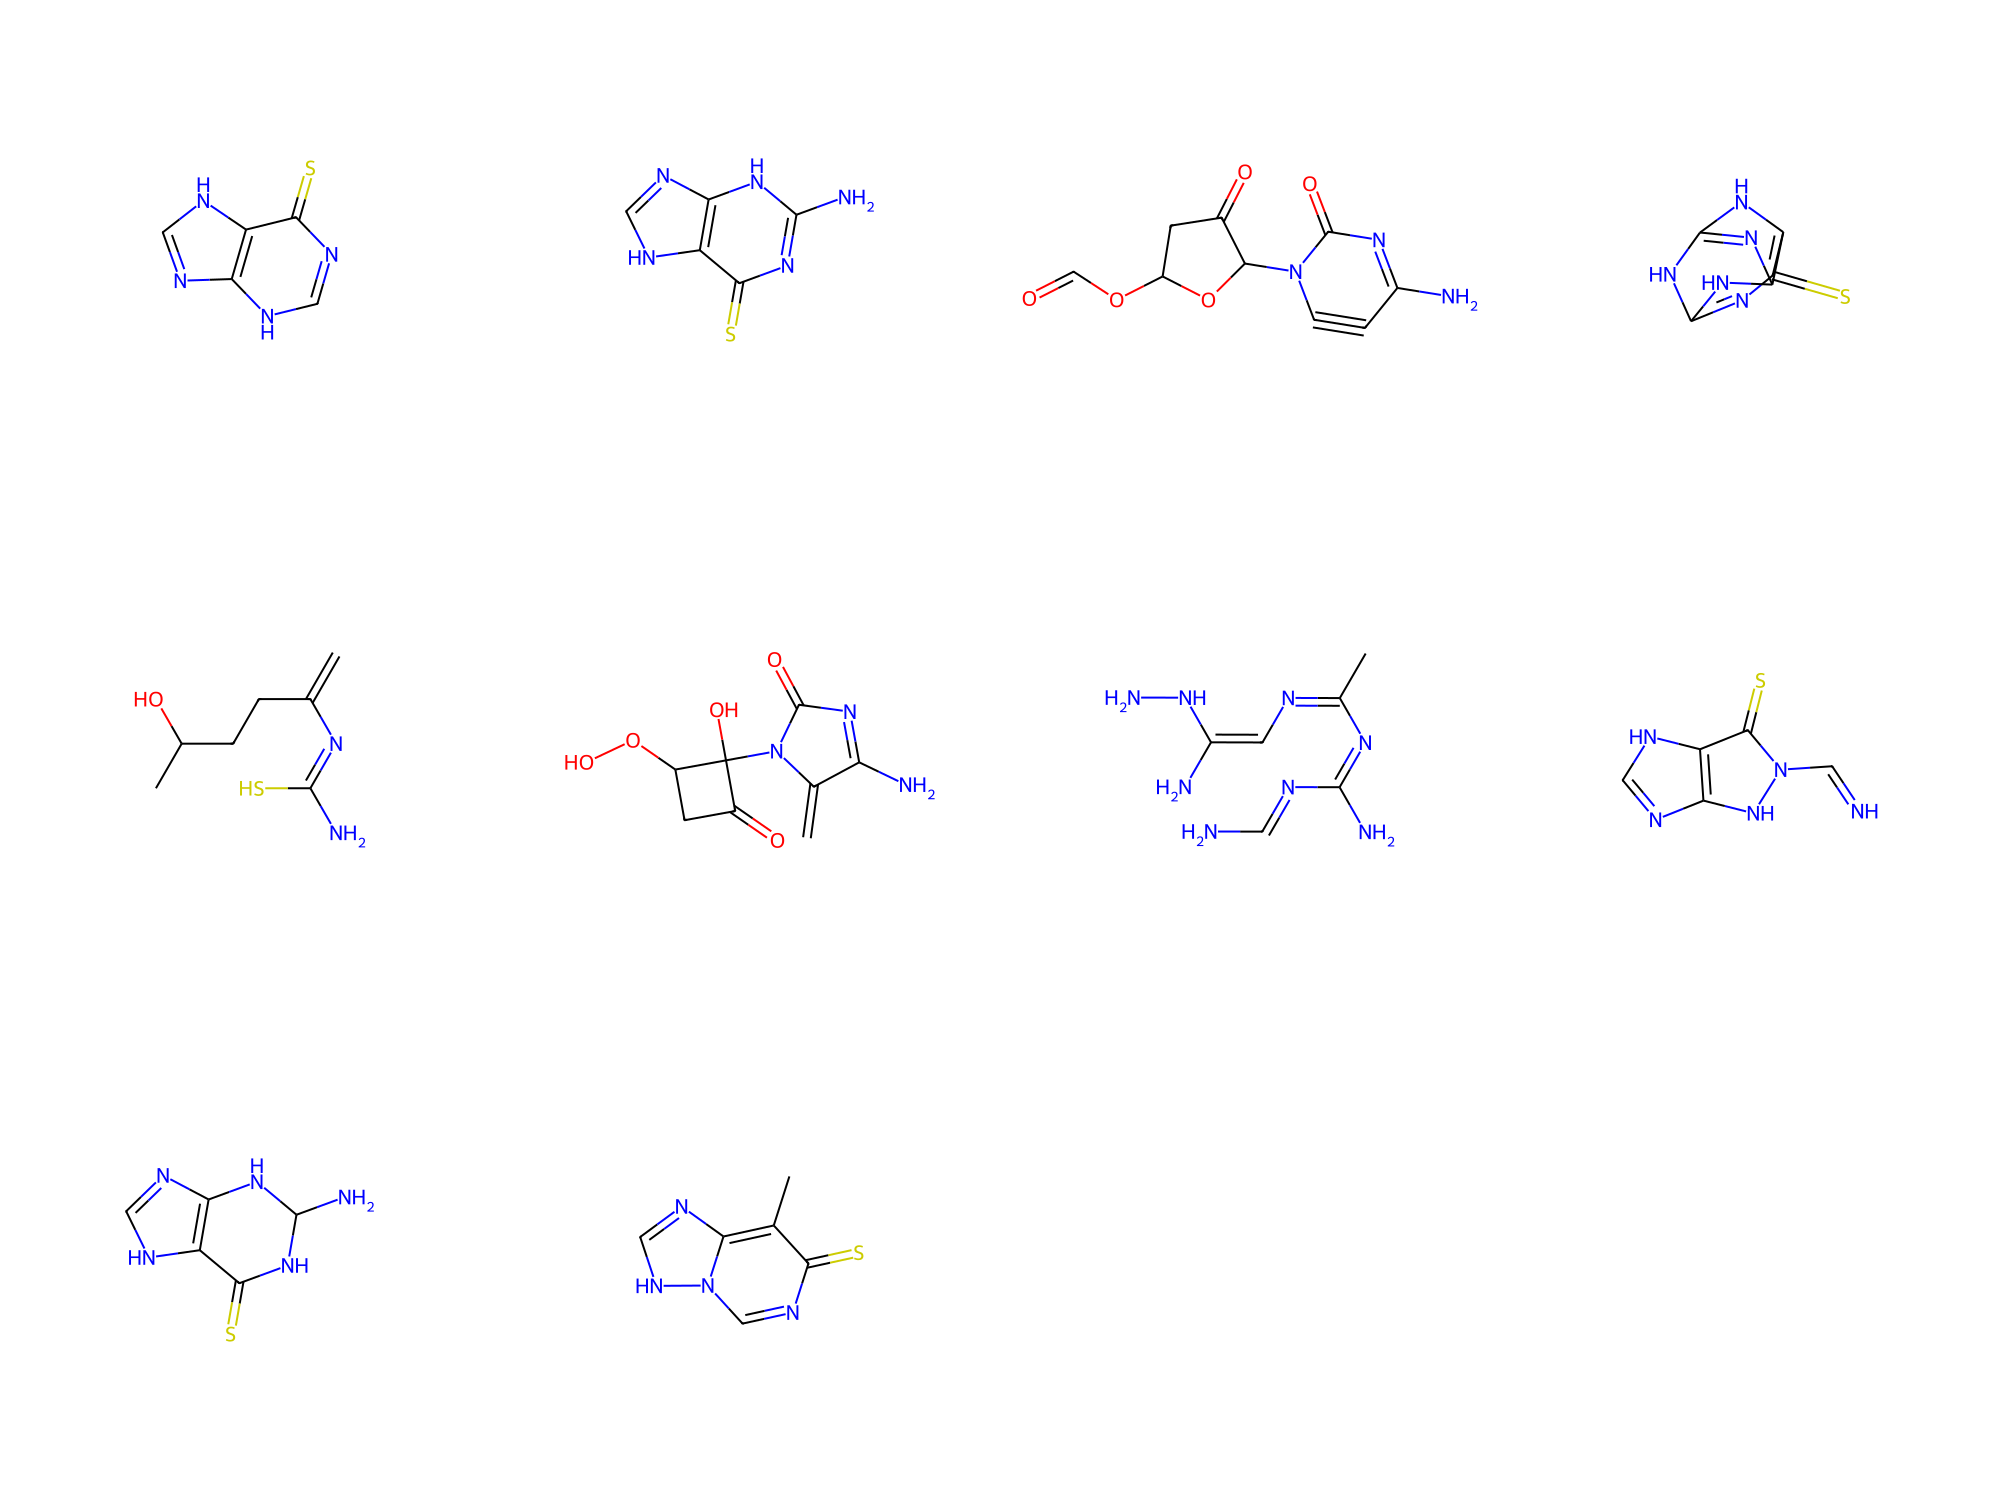

In [23]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in interesting], molsPerRow=4, subImgSize=(500,500))

In [24]:
for mol in interesting:
    labels = ["Lipinski", "PPB", "logVDss", "CYP3A4-inh", "CYP3A4-sub", "CYP2D6-inh", "CYP2D6-sub", "cl-plasma", "t0.5", "DILI", "hERG", "Synthesizability", "Binding Affinity", "HLG"]
    print(mol)
    for i in range(len(labels)):
        print(f"{labels[i]}:", highest_fitness[mol][i])
    print()

S=c1nc[nH]c2nc[nH]c12
Lipinski: -0.0
PPB: 32.45718451953076
logVDss: -0.1267288084954623
CYP3A4-inh: 0.0079818796366453
CYP3A4-sub: -3.0983883334556594e-05
CYP2D6-inh: 3.9284345803025644e-06
CYP2D6-sub: -4.3997115426464006e-05
cl-plasma: 4.879503295135521
t0.5: -1.4554731814232038
DILI: -0.9978681802749634
hERG: 0.022568117827177
Synthesizability: -3.37
Binding Affinity: -2004.302734375
HLG: 88.37371785038022

Nc1nc(=S)c2[nH]cnc2[nH]1
Lipinski: -0.0
PPB: 35.28611630035308
logVDss: -0.3338555039354655
CYP3A4-inh: 0.0001406877709086
CYP3A4-sub: -8.79956060089171e-05
CYP2D6-inh: 6.476370799646247e-06
CYP2D6-sub: -8.104635344352573e-05
cl-plasma: 7.919941531480137
t0.5: -1.6378189764950029
DILI: -0.9990259408950806
hERG: 0.0331790223717689
Synthesizability: -3.304
Binding Affinity: -2264.646484375
HLG: 88.36339653301651

Nc1c#cn(C2OC(OC=O)CC2=O)c(=O)n1


KeyError: 'Nc1c#cn(C2OC(OC=O)CC2=O)c(=O)n1'

## Visualize property evolution


In [25]:
import matplotlib.pyplot as plt

In [26]:
iterations = list(range(len(history)))

In [30]:
labels = ["Lipinski", "PPB", "logVDss", "CYP3A4-inh", "CYP3A4-sub", "CYP2D6-inh", "CYP2D6-sub", "cl-plasma", "t0.5", "DILI", "hERG", "Synthesizability", "Binding Affinity", "HLG"]

average_fitness_scores_per_gen = []
for i in range(len(labels)):
    generational_average = []
    for pop in range(len(history)):
        total = 0
        for score in history[pop]["scores"]:
            total += score[i]

        generational_average.append(total/len(history[pop]["scores"]))

    average_fitness_scores_per_gen.append(generational_average)

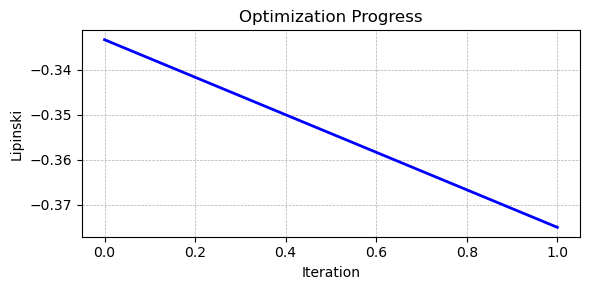

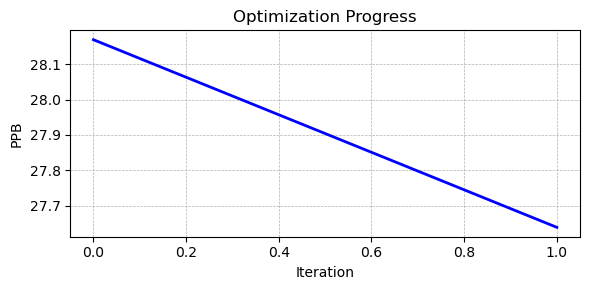

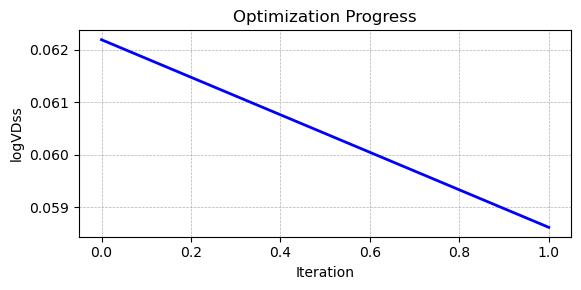

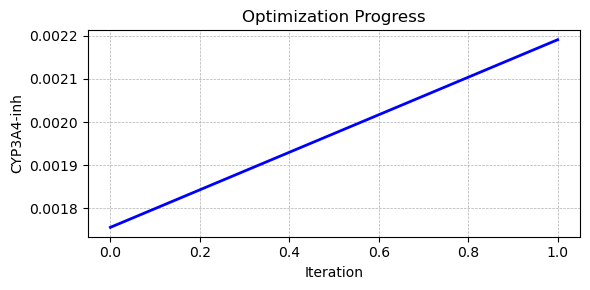

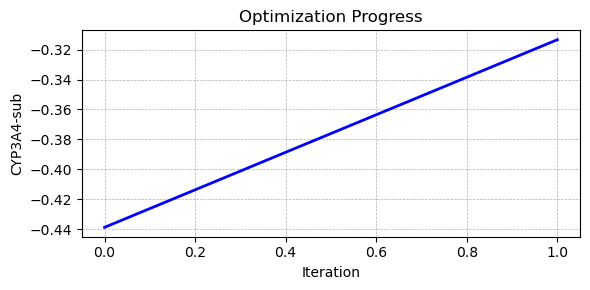

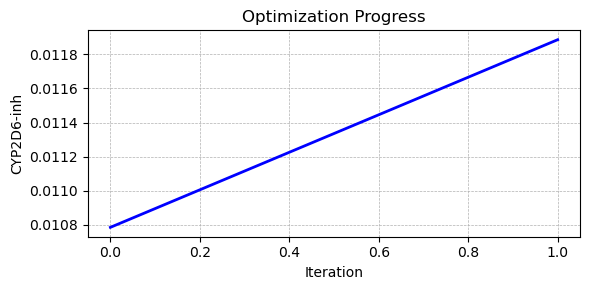

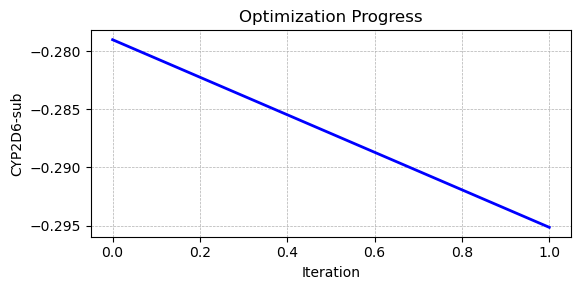

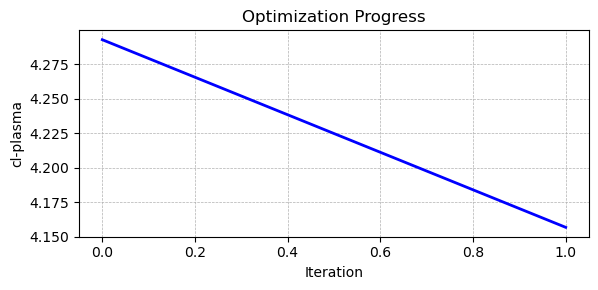

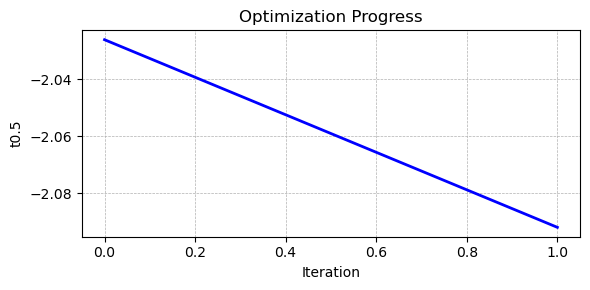

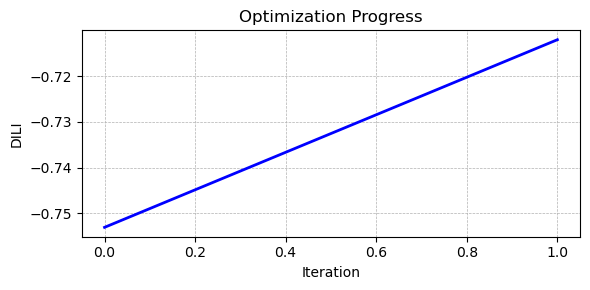

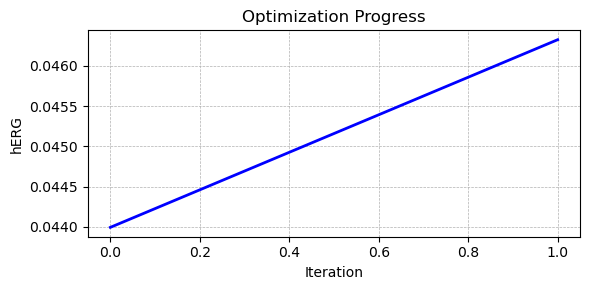

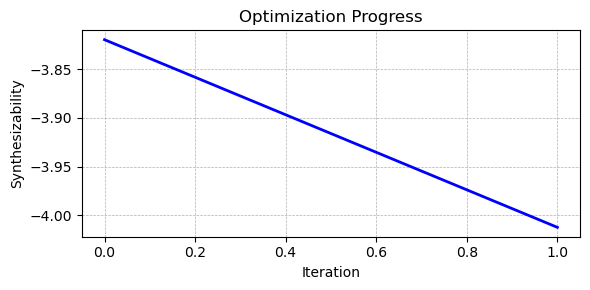

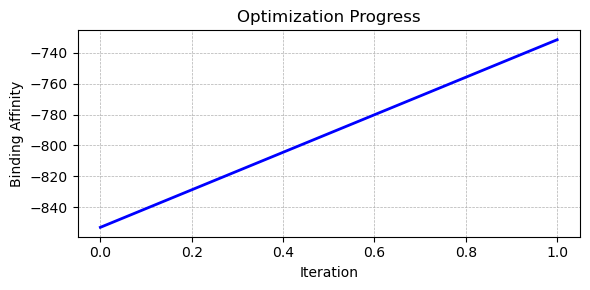

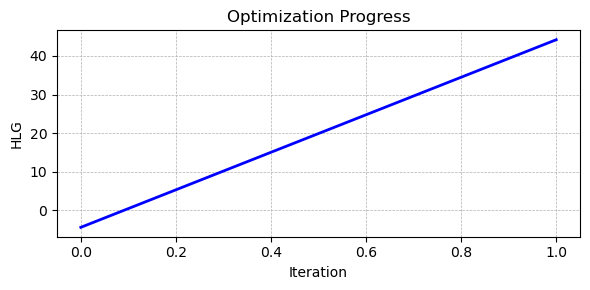

In [50]:
for prop in range(len(labels)):
    # Create the plot
    plt.figure(figsize=(6, 3))
    plt.plot(iterations, average_fitness_scores_per_gen[prop], label=labels[prop], color="blue", linewidth=2)
    plt.title("Optimization Progress")
    plt.xlabel("Iteration")
    plt.ylabel(labels[prop])
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()

    # Show the plot
    plt.show()